# More features

In [2]:
import pandas as pd
import networkx as nx
import matplotlib
import matplotlib.pyplot as plt

from oemof.solph import (Sink, Source, Transformer, Bus, Flow, Model,
                         EnergySystem, Investment, NonConvex)
import oemof.outputlib as outputlib
import oemof.solph as solph
import oemof.graph as graph
from oemof.tools import economics

import pyomo.environ as po

solver = 'cbc'

%matplotlib inline
matplotlib.rcParams['figure.figsize'] = [8.0, 6.0]

In [3]:
color_dict ={
             'coal': '#755d5d',
             'gas': '#c76c56',
             'oil': '#494a19',
             'lignite': '#56201d',
             'wind': '#4ca7c3',
             'pv': '#ffde32',
             'excess_el': '#9a9da1',
             'pp_coal': '#755d5d',
             'pp_gas': '#c76c56',
             'pp_chp': '#eeac7e',
             'b_heat_source': '#cd3333',
             'heat_source': '#cd3333',
             'heat_pump': '#42c77a',
             'electricity': '#0079ff',
             'demand_el': '#0079ff',
             'shortage_el': '#ff2626',
             'excess_el': '#ff2626',
             'biomass': '#01b42e',
             'pp_biomass': '#01b42e'}

In [4]:
def draw_graph(energysystem, edge_labels=True, node_color='#eeac7e',
               edge_color='#eeac7e', plot=True, node_size=5500,
               with_labels=True, arrows=True, layout='dot'):
    
    grph = graph.create_nx_graph(energysystem)
    
    if type(node_color) is dict:
        node_color = [node_color.get(g, '#AFAFAF') for g in grph.nodes()]

    # set drawing options
    options = {
     'prog': 'dot',
     'with_labels': with_labels,
     'node_color': node_color,
     'edge_color': edge_color,
     'node_size': node_size,
     'arrows': arrows,
     'font_size': 12,
     'font_color': 'w'
    }

    # draw graph
    pos = nx.drawing.nx_agraph.graphviz_layout(grph, prog=layout)

    nx.draw(grph, pos=pos, **options)

    # add edge labels for all edges
    if edge_labels is True and plt:
        labels = nx.get_edge_attributes(grph, 'weight')
        nx.draw_networkx_edge_labels(grph, pos=pos, edge_labels=labels)

    # show output
    if plot is True:
        plt.show()

In [5]:
def initialize_basic_energysystem():
    # initialize and provide data
    datetimeindex = pd.date_range('1/1/2016', periods=24*10, freq='H')
    filename = 'input_data.csv'
    data = pd.read_csv(filename, sep=",")
    energysystem = EnergySystem(timeindex=datetimeindex)

    # buses
    bcoal = Bus(label='coal', balanced=False)
    bgas = Bus(label='gas', balanced=False)
    bel = Bus(label='electricity')
    energysystem.add(bcoal, bgas, bel)

    # sources
    energysystem.add(Source(label='wind', outputs={bel: Flow(
        actual_value=data['wind'], nominal_value=66.3, fixed=True)}))

    energysystem.add(Source(label='pv', outputs={bel: Flow(
        actual_value=data['pv'], nominal_value=65.3, fixed=True)}))

    # excess and shortage to avoid infeasibilies
    energysystem.add(Sink(label='excess_el', inputs={bel: Flow()}))
    energysystem.add(Source(label='shortage_el',
                         outputs={bel: Flow(variable_costs=200)}))

    # demands (electricity/heat)
    energysystem.add(Sink(label='demand_el', inputs={bel: Flow(
        nominal_value=85, actual_value=data['demand_el'], fixed=True)}))
    
    return bcoal, bgas, bel, energysystem

# Begin by adding two powerplants

In [6]:
bcoal, bgas, bel, energysystem = initialize_basic_energysystem()

In [7]:
# power plants
energysystem.add(Transformer(
    label='pp_coal',
    inputs={bcoal: Flow()},
    outputs={bel: Flow(nominal_value=20.2, variable_costs=25)},
    conversion_factors={bel: 0.39}))

energysystem.add(Transformer(
    label='pp_gas',
    inputs={bgas: Flow()},
    outputs={bel: Flow(nominal_value=41, variable_costs=40)},
    conversion_factors={bel: 0.50}))

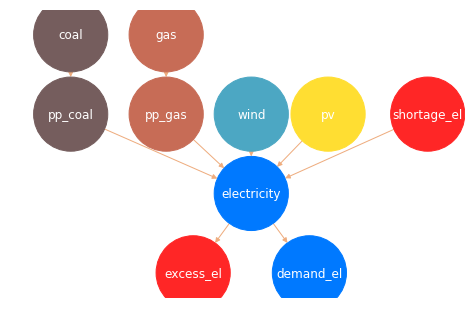

In [8]:
draw_graph(energysystem, node_color=color_dict)

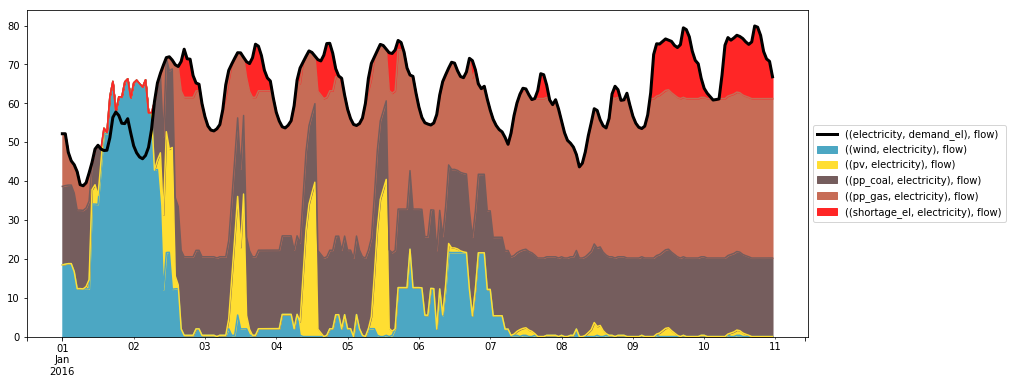

In [9]:
# create optimization model based on energy_system
optimization_model = Model(energysystem=energysystem)

# solve problem
optimization_model.solve(solver=solver,
                         solve_kwargs={'tee': False, 'keepfiles': False})

results = outputlib.processing.results(optimization_model)

results_el = outputlib.views.node(results, 'electricity')
el_sequences = results_el['sequences']
el_prod = el_sequences[[(('wind', 'electricity'), 'flow'),
                        (('pv', 'electricity'), 'flow'),
                        (('pp_coal', 'electricity'), 'flow'),
                        (('pp_gas', 'electricity'), 'flow'),
                        (('shortage_el', 'electricity'), 'flow')]]

fig, ax = plt.subplots(figsize=(14, 6))
for key in el_sequences.keys():
    color_dict[key] = color_dict[key[0][0]] 
c=[color_dict.get(x, '#333333') for x in el_prod.columns]
el_prod.plot.area(ax=ax, color=c)
el_sequences[(('electricity', 'demand_el'), 'flow')].plot(ax=ax, linewidth=3, c='k')
legend = ax.legend(loc='center left', bbox_to_anchor=(1.0, 0.5)) # legend outside of plot

# Investment

In [10]:
bcoal, bgas, bel, energysystem = initialize_basic_energysystem()

In [11]:
# power plants
energysystem.add(Transformer(
    label='pp_coal',
    inputs={bcoal: Flow()},
    outputs={bel: Flow(nominal_value=20.2, variable_costs=25)},
    conversion_factors={bel: 0.39}))

energysystem.add(Transformer(
    label='pp_gas',
    inputs={bgas: Flow()},
    outputs={bel: Flow(nominal_value=41, variable_costs=40)},
    conversion_factors={bel: 0.50}))

epc = economics.annuity(capex=10000, n=20, wacc=0.05)

bbio = Bus(label='biomass', balanced=False)
energysystem.add(bbio)

energysystem.add(Transformer(
    label='pp_biomass',
    inputs={bbio: Flow()},
    outputs={bel: Flow(investment=Investment(ep_costs=epc, maximum=3,
                                             existing=2), variable_costs=25)},
    conversion_factors={bel: 0.39}))

In [12]:
# energysystem.groups['pp_gas'].__dir__()

# energysystem.groups['pp_biomass'].conversion_factors = {bel: 0.39}
# energysystem.groups['pp_biomass'].conversion_factors

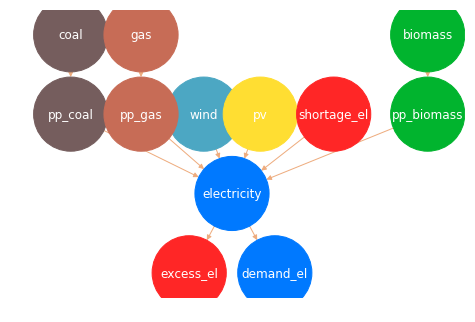

In [13]:
draw_graph(energysystem, node_color=color_dict)

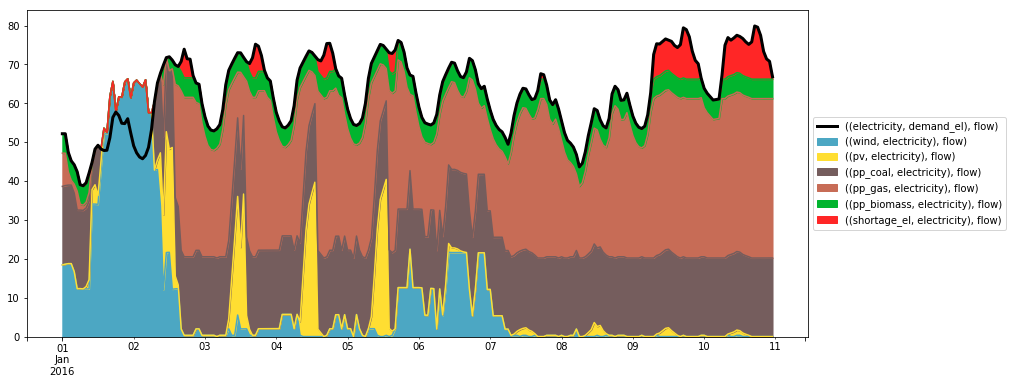

In [14]:
# create optimization model based on energy_system
optimization_model = Model(energysystem=energysystem)

# solve problem
optimization_model.solve(solver=solver,
                         solve_kwargs={'tee': False, 'keepfiles': False})

results = outputlib.processing.results(optimization_model)

results_el = outputlib.views.node(results, 'electricity')

el_sequences = results_el['sequences']
el_prod = el_sequences[[(('wind', 'electricity'), 'flow'),
                        (('pv', 'electricity'), 'flow'),
                        (('pp_coal', 'electricity'), 'flow'),
                        (('pp_gas', 'electricity'), 'flow'),
                        (('pp_biomass', 'electricity'), 'flow'),
                        (('shortage_el', 'electricity'), 'flow')]]


fig, ax = plt.subplots(figsize=(14, 6))
for key in el_sequences.keys():
    color_dict[key] = color_dict[key[0][0]] 
c=[color_dict.get(x, '#333333') for x in el_prod.columns]
el_prod.plot.area(ax=ax, color=c)
el_sequences[(('electricity', 'demand_el'), 'flow')].plot(ax=ax, linewidth=3, c='k')
legend = ax.legend(loc='center left', bbox_to_anchor=(1.0, 0.5)) # legend outside of plot

# Nonconvex components

TODO: Wie setze ich nun eine minimum load?

In [15]:
bcoal, bgas, bel, energysystem = initialize_basic_energysystem()

In [16]:
energysystem.add(solph.Transformer(
    label='pp_gas',
    inputs={bgas: Flow()},
    outputs={bel: Flow(nominal_value=30,
                        nonconvex=NonConvex())},
    conversion_factors={bel: 0.3}))

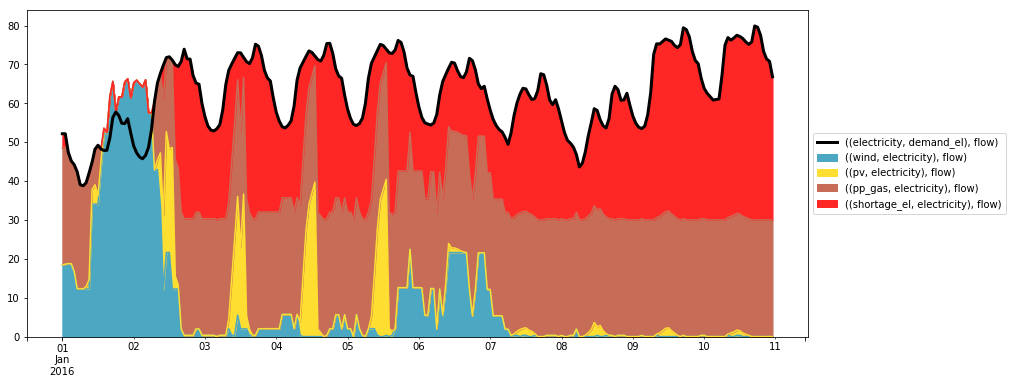

In [17]:
# create optimization model based on energy_system
optimization_model = Model(energysystem=energysystem)

# solve problem
optimization_model.solve(solver=solver,
                         solve_kwargs={'tee': False, 'keepfiles': False})

results = outputlib.processing.results(optimization_model)

results_el = outputlib.views.node(results, 'electricity')

el_sequences = results_el['sequences']
el_prod = el_sequences[[(('wind', 'electricity'), 'flow'),
                        (('pv', 'electricity'), 'flow'),
                        (('pp_gas', 'electricity'), 'flow'),
                        (('shortage_el', 'electricity'), 'flow')]]

fig, ax = plt.subplots(figsize=(14, 6))
for key in el_sequences.keys():
    color_dict[key] = color_dict[key[0][0]]
c=[color_dict.get(x, '#333333') for x in el_prod.columns]
el_prod.plot.area(ax=ax, color=c)
el_sequences[(('electricity', 'demand_el'), 'flow')].plot(ax=ax, linewidth=3, c='k')
legend = ax.legend(loc='center left', bbox_to_anchor=(1.0, 0.5)) # legend outside of plot

# Additional constraints

* emission constraints
* overall investment constraint
* equate two variables

In [55]:
bcoal, bgas, bel, energysystem = initialize_basic_energysystem()

# power plants
energysystem.add(Transformer(
    label='pp_coal',
    inputs={bcoal: Flow()},
    outputs={bel: Flow(nominal_value=20.2, variable_costs=25)},
    conversion_factors={bel: 0.39}))

pp_gas = Transformer(
    label='pp_gas',
    inputs={bgas: Flow()},
    outputs={bel: Flow(nominal_value=41, variable_costs=40)},
    conversion_factors={bel: 0.50})
energysystem.add(pp_gas)

In [58]:
# create the model
optimization_model = Model(energysystem)

# add specific emission values to flow objects if source is a commodity bus
for s, t in optimization_model.flows.keys():
    if s is bgas:
        optimization_model.flows[s, t].emission_factor = 0.27  # t/MWh
    if s is bcoal:
        optimization_model.flows[s, t].emission_factor = 0.39  # t/MWh
emission_limit = 60e1

# add the outflow share
optimization_model.flows[(bgas, pp_gas)].outflow_share = [1] * 240

# Add a new pyomo Block
myblock = po.Block()

# create a pyomo set with the flows (i.e. list of tuples),
# there will of course be only one flow inside this set, the one we used to
# add outflow_share
myblock.MYFLOWS = [k for (k, v) in optimization_model.flows.items()
                                     if hasattr(v, 'outflow_share')]


# pyomo does not need a po.Set, we can use a simple list as well
myblock.COMMODITYFLOWS = [k for (k, v) in optimization_model.flows.items()
                          if hasattr(v, 'emission_factor')]


# add the sub-model to the oemof Model instance
optimization_model.add_component('MyBlock', myblock)

def _inflow_share_rule(model, s, e, time):
    """pyomo rule definition: Here we can use all objects from the block or
    the om object, in this case we don't need anything from the block
    except the newly defined set MYFLOWS.
    """
    expr = (optimization_model.flow[s, e, time] >= optimization_model.flows[s, e].outflow_share[time] *
            sum(optimization_model.flow[i, o, time] for (i, o) in optimization_model.FLOWS if o == e))
    return expr

# Add inflow share constraint
myblock.inflow_share = po.Constraint(myblock.MYFLOWS, optimization_model.TIMESTEPS,
                                     rule=_inflow_share_rule)
# add emission constraint
myblock.emission_constr = po.Constraint(expr=(
        sum(optimization_model.flow[i, o, t]
            for (i, o) in myblock.COMMODITYFLOWS
            for t in optimization_model.TIMESTEPS) <= emission_limit))

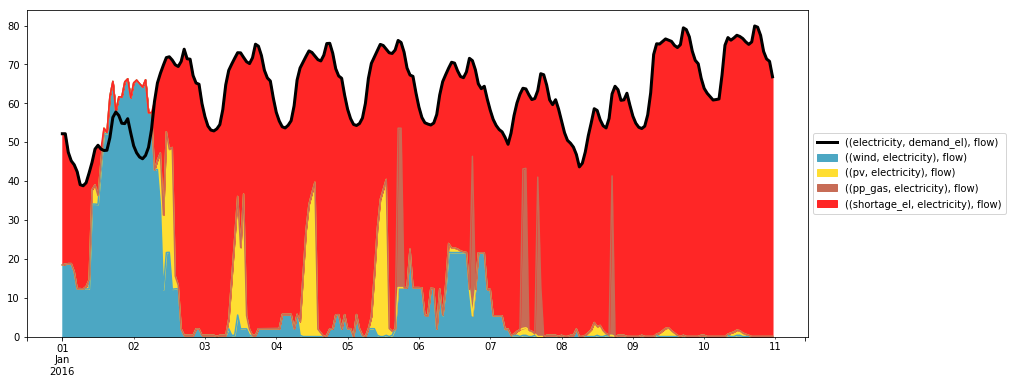

In [59]:
# solve problem
optimization_model.solve(solver=solver,
                         solve_kwargs={'tee': False, 'keepfiles': False})

results = outputlib.processing.results(optimization_model)

results_el = outputlib.views.node(results, 'electricity')

el_sequences = results_el['sequences']
el_prod = el_sequences[[(('wind', 'electricity'), 'flow'),
                        (('pv', 'electricity'), 'flow'),
                        (('pp_gas', 'electricity'), 'flow'),
                        (('shortage_el', 'electricity'), 'flow')]]

fig, ax = plt.subplots(figsize=(14, 6))
for key in el_sequences.keys():
    color_dict[key] = color_dict[key[0][0]]
c=[color_dict.get(x, '#333333') for x in el_prod.columns]
el_prod.plot.area(ax=ax, color=c)
el_sequences[(('electricity', 'demand_el'), 'flow')].plot(ax=ax, linewidth=3, c='k')
legend = ax.legend(loc='center left', bbox_to_anchor=(1.0, 0.5)) # legend outside of plot

In [47]:
bcoal, bgas, bel, energysystem = initialize_basic_energysystem()

# power plants
energysystem.add(Transformer(
    label='pp_coal',
    inputs={bcoal: Flow()},
    outputs={bel: Flow(nominal_value=20.2, variable_costs=25)},
    conversion_factors={bel: 0.39}))

energysystem.add(Transformer(
    label='pp_gas',
    inputs={bgas: Flow()},
    outputs={bel: Flow(nominal_value=41, variable_costs=40)},
    conversion_factors={bel: 0.50}))

# create optimization model based on energy_system
optimization_model = Model(energysystem=energysystem)


flow_dict = dict()
for s, t in optimization_model.flows.keys():
    if s is bcoal:
        optimization_model.flows[s, t].emission_factor = 0.27  # t/MWh
        print('a',optimization_model.flows[s, t])
    if s is bgas:
        print('b',optimization_model.flows[s, t])
        optimization_model.flows[s, t].emission_factor = 0.39  # t/MWh

from oemof.solph.constraints import emission_limit as emission_limit
emission_limit(optimization_model, flows=flow_dict, limit=[1000.]*1000)

# solve problem
optimization_model.solve(solver=solver,
                         solve_kwargs={'tee': False, 'keepfiles': False})

results = outputlib.processing.results(optimization_model)

results_el = outputlib.views.node(results, 'electricity')
el_sequences = results_el['sequences']
el_prod = el_sequences[[(('wind', 'electricity'), 'flow'),
                        (('pv', 'electricity'), 'flow'),
                        (('pp_coal', 'electricity'), 'flow'),
                        (('pp_gas', 'electricity'), 'flow'),
                        (('shortage_el', 'electricity'), 'flow')]]

fig, ax = plt.subplots(figsize=(14, 6))
for key in el_sequences.keys():
    color_dict[key] = color_dict[key[0][0]] 
c=[color_dict.get(x, '#333333') for x in el_prod.columns]
el_prod.plot.area(ax=ax, color=c)
el_sequences[(('electricity', 'demand_el'), 'flow')].plot(ax=ax, linewidth=3, c='k')
legend = ax.legend(loc='center left', bbox_to_anchor=(1.0, 0.5)) # legend outside of plot

ERROR:pyomo.core:Rule failed when generating expression for constraint emission_limit:
TypeError: '<=' not supported between instances of 'int' and 'list'
ERROR:pyomo.core:Constructing component 'emission_limit' from data=None failed:
TypeError: '<=' not supported between instances of 'int' and 'list'


a EdgeLabel(input="<oemof.solph.network.Bus: 'coal'>", output="<oemof.solph.network.Transformer: 'pp_coal'>")
b EdgeLabel(input="<oemof.solph.network.Bus: 'gas'>", output="<oemof.solph.network.Transformer: 'pp_gas'>")
ERROR: Rule failed when generating expression for constraint emission_limit:
    TypeError: '<=' not supported between instances of 'int' and 'list'
ERROR: Constructing component 'emission_limit' from data=None failed:
    TypeError: '<=' not supported between instances of 'int' and 'list'


TypeError: '<=' not supported between instances of 'int' and 'list'

# Startup costs

pp1 and pp2 are competing to serve overall 12 units load at lowest cost
summed costs for pp1 = 12 * 10 * 10.25 = 1230
summed costs for pp2 = 4*5 + 4*5 + 12 * 10 * 10 = 1240
=> pp1 serves the load despite of higher variable costs since
   the start and shutdown costs of pp2 change its marginal costs

In [38]:
bcoal, bgas, bel, energysystem = initialize_basic_energysystem()

In [39]:
energysystem.add(Source(
    label='pp_coal',
    outputs={bel: solph.Flow(nominal_value=10, variable_costs=10.25)}))

# shutdown costs only work in combination with a minimum load
# since otherwise the status variable is "allowed" to be active i.e.
# it permanently has a value of one which does not allow to set the shutdown
# variable which is set to one if the status variable changes from one to zero
energysystem.add(Source(
    label='pp_gas',
    outputs={
        bel: solph.Flow(
            nominal_value=10, min=0.5, max=1.0, variable_costs=10,
            nonconvex=solph.NonConvex(startup_costs=5, shutdown_costs=5))}))

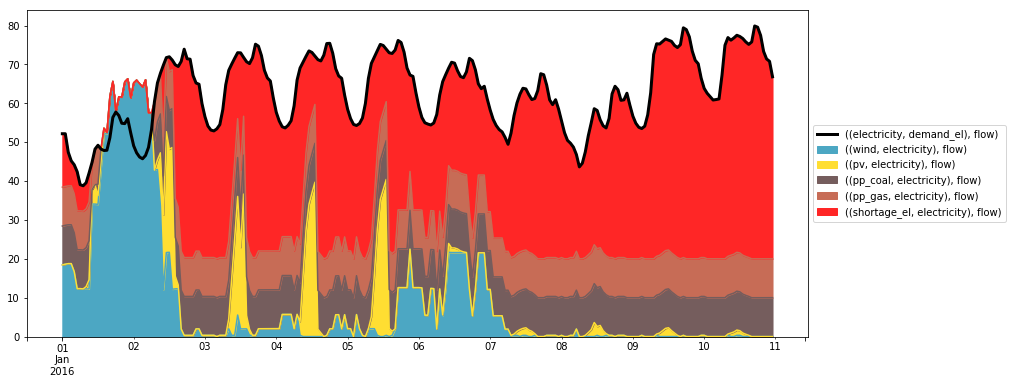

In [40]:
# create optimization model based on energy_system
optimization_model = Model(energysystem=energysystem)

# solve problem
optimization_model.solve(solver=solver,
                         solve_kwargs={'tee': False, 'keepfiles': False})

results = outputlib.processing.results(optimization_model)

results_el = outputlib.views.node(results, 'electricity')
el_sequences = results_el['sequences']
el_prod = el_sequences[[(('wind', 'electricity'), 'flow'),
                        (('pv', 'electricity'), 'flow'),
                        (('pp_coal', 'electricity'), 'flow'),
                        (('pp_gas', 'electricity'), 'flow'),
                        (('shortage_el', 'electricity'), 'flow')]]

fig, ax = plt.subplots(figsize=(14, 6))
for key in el_sequences.keys():
    color_dict[key] = color_dict[key[0][0]] 
c=[color_dict.get(x, '#333333') for x in el_prod.columns]
el_prod.plot.area(ax=ax, color=c)
el_sequences[(('electricity', 'demand_el'), 'flow')].plot(ax=ax, linewidth=3, c='k')
legend = ax.legend(loc='center left', bbox_to_anchor=(1.0, 0.5)) # legend outside of plot

# Minimum up and down times

In [41]:
bcoal, bgas, bel, energysystem = initialize_basic_energysystem()

In [42]:
energysystem.add(Source(
    label='pp_coal',
    outputs={
        bel: solph.Flow(
            nominal_value=10, min=0.5, max=1.0, variable_costs=10,
            nonconvex=solph.NonConvex(
                minimum_downtime=4, initial_status=0))}))

energysystem.add(Source(
    label='pp_gas',
    outputs={
        bel: solph.Flow(
            nominal_value=10, min=0.5, max=1.0, variable_costs=10,
            nonconvex=solph.NonConvex(
                minimum_uptime=2, initial_status=1))}))

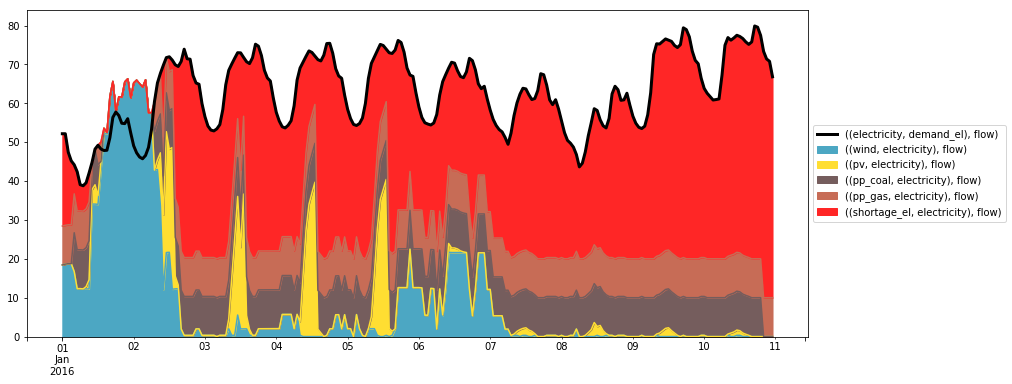

In [43]:
# create optimization model based on energy_system
optimization_model = Model(energysystem=energysystem)

# solve problem
optimization_model.solve(solver=solver,
                         solve_kwargs={'tee': False, 'keepfiles': False})

results = outputlib.processing.results(optimization_model)

results_el = outputlib.views.node(results, 'electricity')
el_sequences = results_el['sequences']
el_prod = el_sequences[[(('wind', 'electricity'), 'flow'),
                        (('pv', 'electricity'), 'flow'),
                        (('pp_coal', 'electricity'), 'flow'),
                        (('pp_gas', 'electricity'), 'flow'),
                        (('shortage_el', 'electricity'), 'flow')]]

fig, ax = plt.subplots(figsize=(14, 6))
for key in el_sequences.keys():
    color_dict[key] = color_dict[key[0][0]] 
c=[color_dict.get(x, '#333333') for x in el_prod.columns]
el_prod.plot.area(ax=ax, color=c)
el_sequences[(('electricity', 'demand_el'), 'flow')].plot(ax=ax, linewidth=3, c='k')
legend = ax.legend(loc='center left', bbox_to_anchor=(1.0, 0.5)) # legend outside of plot

# Postprocessing

How to get costs, etc.